In [1]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict

import dvu
import matplotlib.pyplot as plt
import pandas as pd
from os.path import join
import numpy as np
import seaborn as sns
import sys
sys.path.append('../notebooks_llm/')
plt.style.use('default')
dvu.set_style()
UNKS = {"Unk", "-", -1, "-1"}
df = pd.read_pickle('../data/data_clean.pkl')

### Overall study counts

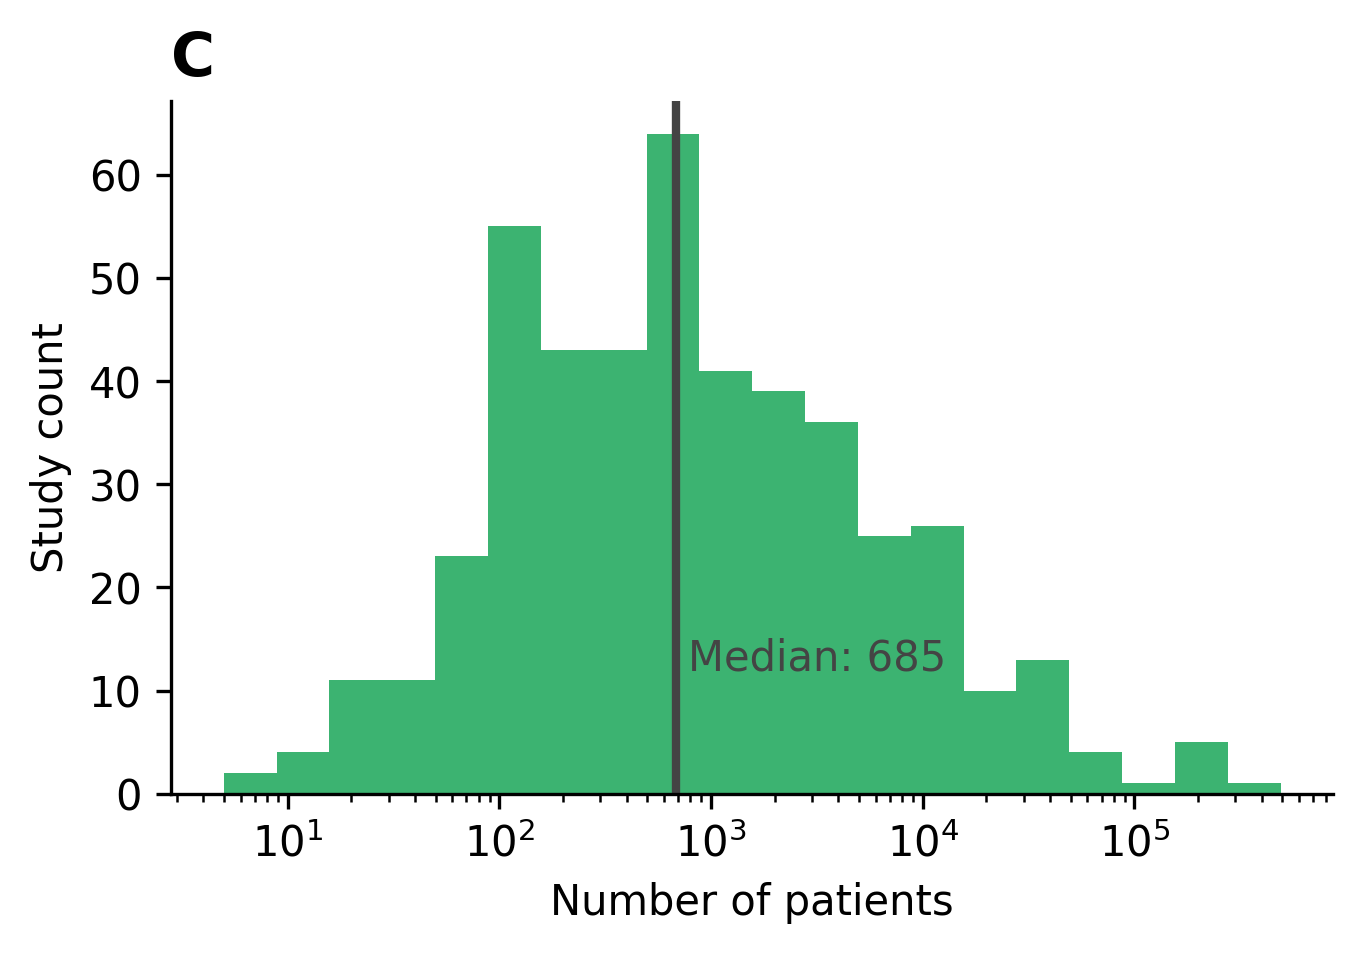

In [2]:
x = df['participants___total']
x = x[x > 0]
hist, bins, _ = plt.hist(x, bins=20)
plt.cla()
plt.close()
# histogram on log scale.
# Use non-equal bin sizes, such that they look equal on log scale.
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
plt.figure(dpi=300, figsize=(5, 3))
avg = np.median(x)
plt.axvline(x=avg, ls='-', color='#444', lw=2)
plt.text(s=f'Median: {avg:,.0f}', x=avg + 90, y=12, color='#444')
plt.hist(x, bins=logbins, color='mediumseagreen')
plt.xscale("log")
plt.xlabel('Number of patients')
plt.ylabel('Study count')
plt.title('C', loc='left', fontsize='x-large', fontweight='bold')
plt.show()

### Race ratios

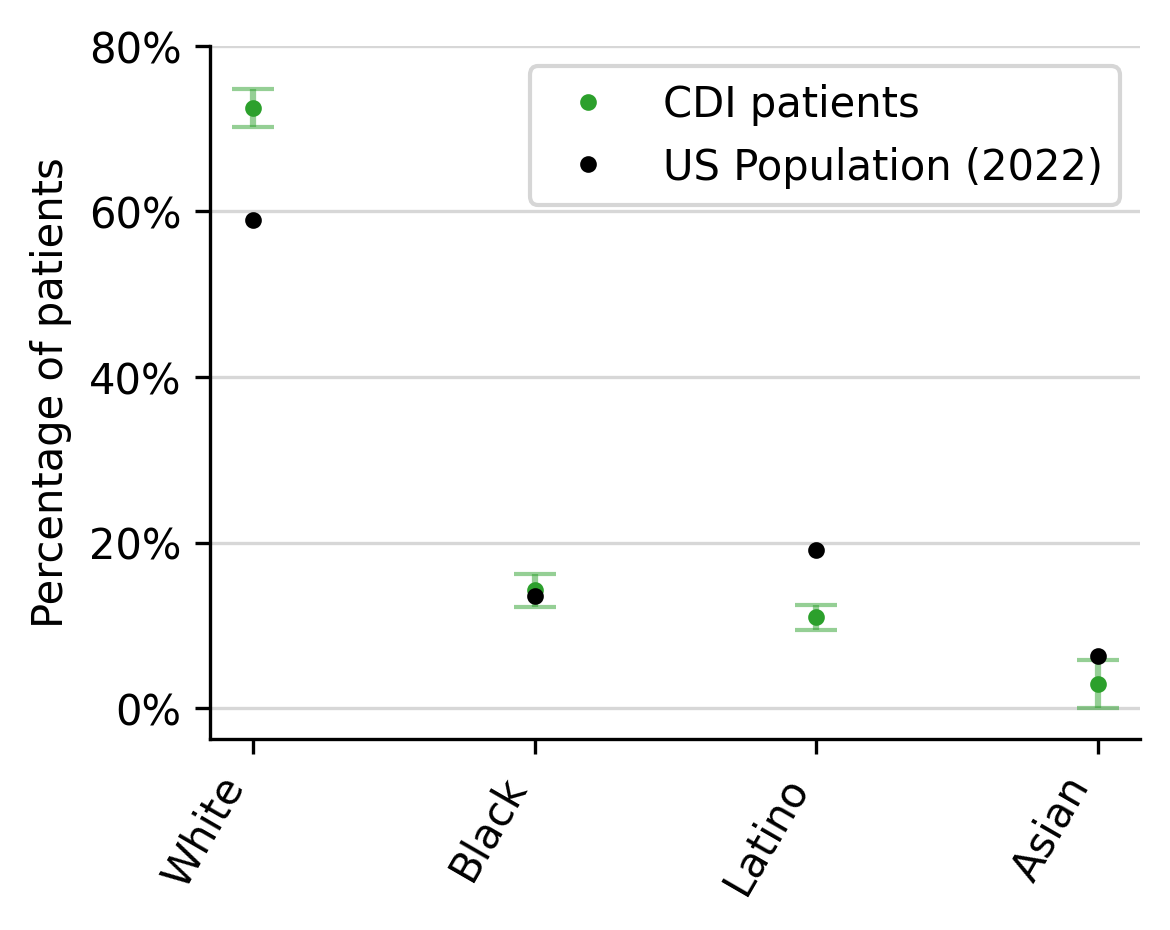

In [21]:
race_keys = [
    "participants___white",
    "participants___black",
    "participants___latino",
    "participants___asian",
]
CENSUS_NUMS = {
    "White": 58.9,
    "Black": 13.6,
    "Latino": 19.1,
    "Asian": 6.3,
}
vals_dict = defaultdict(list)
for k in race_keys:
    idxs = df[k].notnull() & ~(df[k].isin(UNKS))
    d = df[idxs]
    vals = df[k][idxs]
    vals_perc = []
    for i, v in vals.items():
        # if eval_extraction.str_is_percentage(v):
        # vals_perc.append(eval_extraction.percentage_to_num(v))
        # else:

        vals_perc.append(100 * float(v) / d["participants___total"][i])
        assert (
            vals_perc[-1] <= 100 and vals_perc[-1] >= 0
        ), f"key={k} original_val={v} val_percentage={vals_perc[-1]} {d['participants___total'][i]}"
    # vals = [float(v[:-1]) for v in vals]
    # print(vals.values, vals_perc)
    vals_dict[k] = vals_perc

# make boxplot
plt.figure(figsize=(4, 3), dpi=300)


# draw arrows from CDI patients to US Census
# for i, (k, v) in enumerate(vals_dict.items()):
#     val = CENSUS_NUMS[list(CENSUS_NUMS.keys())[i]]
#     plt.annotate(
#         "",
#         xy=(i, val),
#         xytext=(i, np.median(v)),
#         arrowprops=dict(arrowstyle="<-", color="gray", alpha=1),
#     )

for i, (k, v) in enumerate(vals_dict.items()):
    kwargs = {}
    if i == len(vals_dict) - 1:
        kwargs["label"] = "CDI patients"

    # plt.plot(np.random.normal(i, 0.05, len(v)), v, 'o', alpha=0.5, color='C2', ms=2, **kwargs)
    plt.plot(i, np.median(v), "o", color="C2", ms=3, **kwargs)  # , ms=3)
    plt.errorbar(
        i,
        np.median(v),
        yerr=np.std(v) / np.sqrt(len(v)),
        color="C2",
        capsize=5,
        alpha=0.5,
    )  # , ms=3)

    if i == len(vals_dict) - 1:
        kwargs["label"] = "US Population (2022)"
    # plot census
    val = CENSUS_NUMS[list(CENSUS_NUMS.keys())[i]]
    plt.plot(i, val, "o", color="black", ms=3, **kwargs)  # , ms=3)


plt.legend()
plt.xticks(
    labels=["White", "Black", "Latino", "Asian"],
    ticks=range(4),
    rotation=60,
    ha="right",
)
plt.yticks(ticks=range(0, 100, 20), labels=[f"{t}%" for t in range(0, 100, 20)])
plt.ylabel("Percentage of patients")
plt.grid(axis="y", alpha=0.5)
plt.show()

# Author affilliation plots

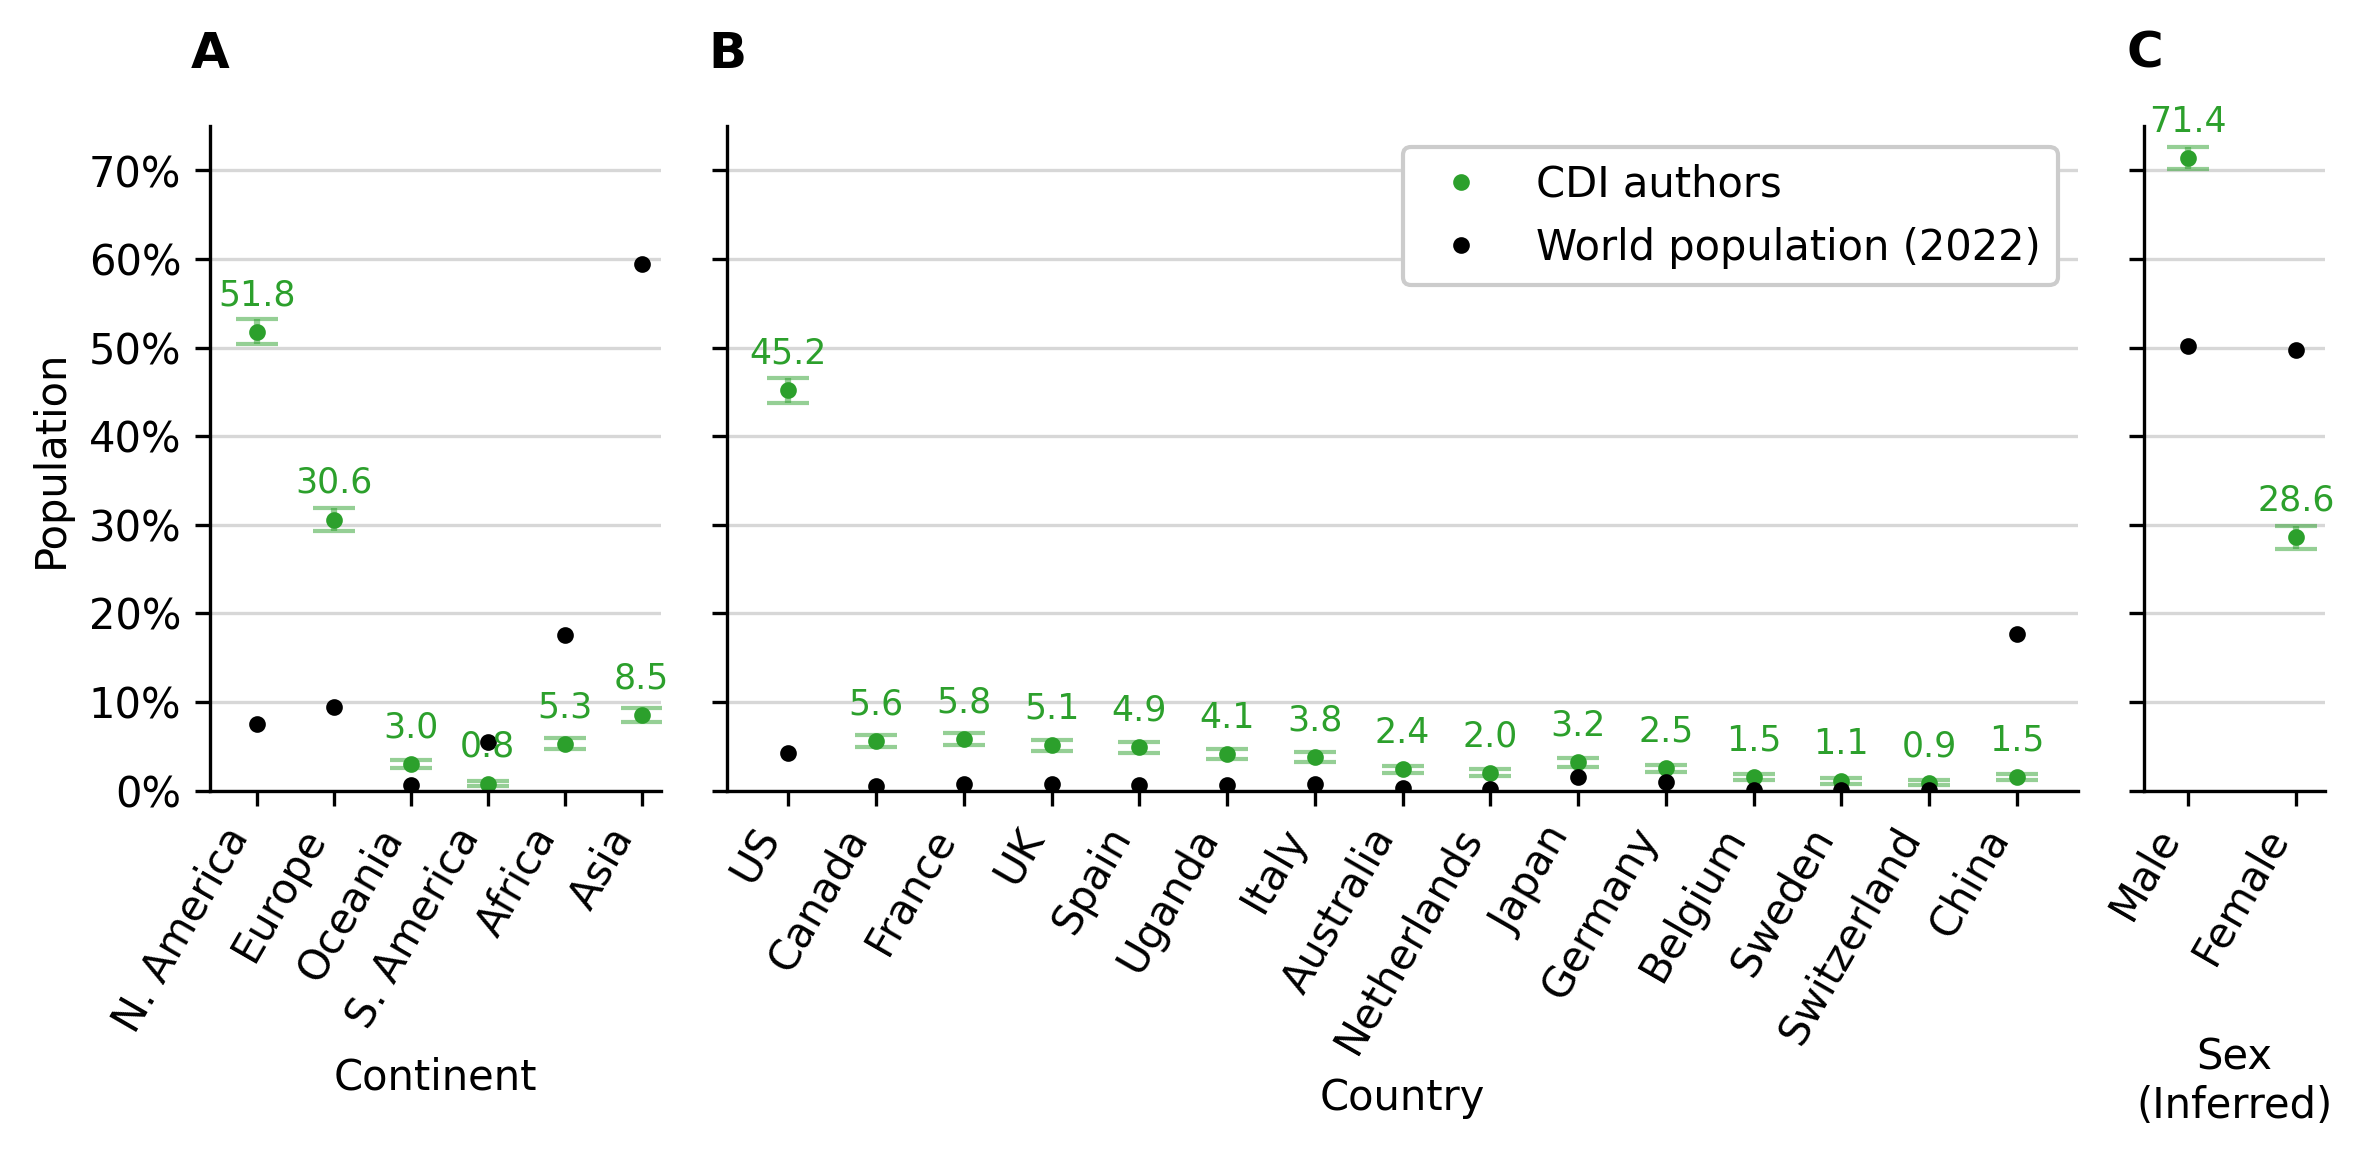

In [22]:
def to_num(x):
    return float(x.replace("%", ""))


def make_plot(tab, ax):
    # plot with no connecting line
    ax.plot(
        tab["CDI Author affiliations"].apply(to_num),
        label="CDI authors",
        color="C2",
        marker="o",
        ms=3,
        linestyle="None",
    )

    # annotate value above each point
    for i, v in enumerate(tab["CDI Author affiliations"].apply(to_num)):
        ax.annotate(
            f"{v}",
            (i, v),
            xytext=(i, v + 3),
            ha="center",
            color="C2",
            fontsize="small",
        )


    def calc_bernoulli_sem(fracs, n):
        return np.sqrt(fracs * (1 - fracs) / n)


    sems = calc_bernoulli_sem(tab["CDI Author affiliations"].apply(to_num) / 100, n=1234)
    ax.errorbar(
        range(len(tab)),
        tab["CDI Author affiliations"].apply(to_num),
        yerr=sems * 100,
        color="C2",
        capsize=5,
        alpha=0.5,
        linestyle="None",
    )

    ax.plot(
        tab["World population (UN Geoscheme, 2021)"].apply(to_num),
        label="World population (2022)",
        color="black",
        marker="o",
        ms=3,
        linestyle="None",
    )

    ax.grid(axis="y", alpha=0.5)
    ax.set_xticks(labels=tab.index.values, ticks=range(len(tab)), rotation=60, ha="right")

# fig = plt.figure(figsize=(9, 3), dpi=300)
f, axes = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 3, 0.4]}, dpi=300, figsize=(8, 4))
tits = ['Continent', 'Country', '\nSex\n(Inferred)']
for i, k in enumerate(['continents', 'countries', 'gender']):
    ax = axes[i]
    # plt.subplot(1, 3, i + 1, width_ratios=[1, 2, 1])
    tab = pd.read_csv(f'../data/author_affil_{k}.csv', header=0)
    tab = tab.rename(columns={'Unnamed: 0': 'Source'})
    tab = tab.set_index('Source')
    # tab = tab.set_index('Unnamed: 0') # = tab['Unnamed: 0']
    tab = tab.T
    make_plot(tab, ax)

    yticks = range(0, 75, 10)
    ax.set_yticks(ticks=yticks, labels=[f"{t}%" for t in yticks])
    ax.set_ylim(bottom=0, top=75)
    if i == 0:    
        ax.set_ylabel("Population")
    else:
        # hide y axis
        # ax.set_yticks([])
        ax.set_yticklabels([])

    ax.set_title('ABC'[i], x=0, y=1.05, fontweight='bold')

    if i == 1:
        # plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), ncol=1)

        # set legend background to white with no transparency
        ax.legend(facecolor='w', framealpha=1)

    if i == 0:
        ax.set_xlim(left=-0.6)
    if i == 2:
        ax.set_xlim(left=-0.4, right=ax.get_xlim()[1] * 1.2)
    ax.set_xlabel(tits[i])

    # put legend above plot
    # if i == 1:
        # plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=2)
# make shared legend above all subplots
# fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=2)
# plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=2)

# make legend to the right of plot
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)